# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample File and Declaring XGA ClusterSample

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [ ]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:15<00:32,  1.03s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:19<00:29,  1.08s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  50%|██████████████████████                      | 25/50 [00:20<00:17,  1.40it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source RXCJ1212.3-1816 does not appear to have any XMM dat

## Running PSF Correction

In [4]:
rl_psf(locuss_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 45/45 [00:04<00:00, 10.53it/s]


## Reading in literature data

### Gas masses from literature

In [5]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [6]:
loc_conv_txs = []
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [7]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 45/45 [00:18<00:00,  2.37it/s]
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [17:38<00:00, 23.53s/it]


In [9]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [25:28<00:00, 33.97s/it]


In [11]:
loc_beta_king_13_gm500 = []
loc_beta_king_13_gm2500 = []

with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_13_gm2500.append(gm)
        else:
            loc_beta_king_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_13_gm500.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)               
        
loc_beta_king_13_gm500 = Quantity(loc_beta_king_13_gm500, 'Msun')
loc_beta_king_13_gm2500 = Quantity(loc_beta_king_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [01:39<00:00,  2.21s/it]


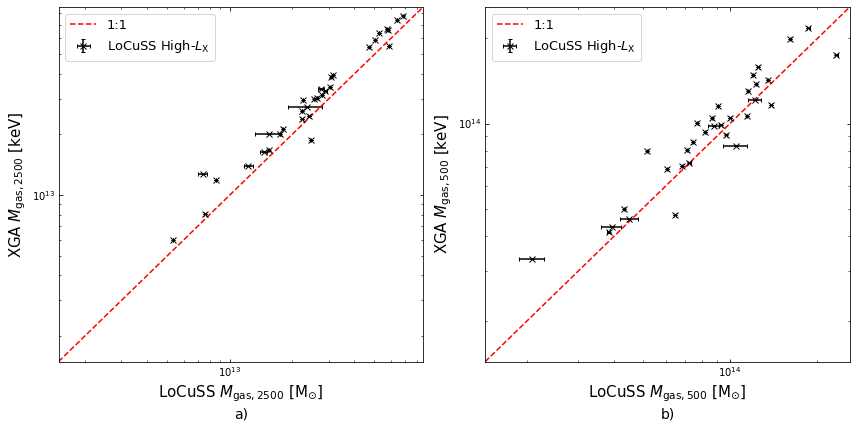

In [12]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_13_gm2500, loc_beta_king_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [13]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [14]:
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 926.53734087  586.99421242 1083.02711931  852.19590747  954.02432942
  942.74219556]


Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:25<18:59, 25.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [555.07639522 408.79448021 535.86148648 328.72624098 354.84402898
 496.32073259]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:20<18:35, 26.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1233.19127485  991.99190683 1904.25958478 1574.16728375 1725.87636066
 1838.89607122]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:44<17:32, 25.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 571.42311859 1006.72073605 1156.37018346  834.63547283  918.27001824
 1125.93914145]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/45 [02:35<16:34, 25.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [137.65687692 423.30111368 407.08935772 309.98418416 354.15630855
 439.63288047]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏      | 7/45 [03:02<16:33, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 362.8363458   181.57723189 1843.39728076 1699.63249172 1769.40087486
 1716.50589319]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 11/45 [04:50<15:04, 26.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [181.97799154 370.72707283 556.59676872 149.18482446 152.05914165
 164.58634782]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:43<14:04, 26.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1595.48658739  903.18708845 1978.24745701 2042.0118495  2076.76720417
 1981.68956764]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [963.95391255 314.91730323 906.41640283 854.93913232 914.62139561
 972.84373387]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/45 [06:38<13:23, 26.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [456.28796002 439.16707838 305.93803678 310.56163881 352.6619542
 457.44867612]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [198.77181254 350.41404204 382.38597422 483.52593586 434.26042453
 415.78468045]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [07:03<12:47, 26.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 624.11155562  445.58266815 1571.92826011 1158.75803159 1223.96235725
 1407.10328328]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 18/45 [07:53<11:27, 25.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1505.79181478  365.01845231 2354.53090303  812.93231182 1057.60395506
 2355.56895502]


Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 20/45 [08:51<11:23, 27.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [454.34272349 429.97483708 299.43742289 253.15716416 274.59245296
 375.69830003]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 22/45 [09:49<10:51, 28.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1810.17591969  287.92024831 2521.51063441 2350.68451074 1224.1982322
 2506.09956618]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 23/45 [10:15<10:05, 27.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 653.45231629 1535.64275368 1582.79575652 1047.37899375 1611.68934953
 1574.25067987]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:36<08:34, 27.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1820.05739599  289.45534929 2089.08500703  767.75530801  570.70037488
 2086.06598926]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 430.36422587  490.36443447 1622.59045119 1335.61229536  616.39285991
  420.17274129]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [14:23<05:55, 27.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 867.70126626  609.56185303 1797.81640411 1400.64646187 1188.17030156
 1799.76937524]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████▏ | 33/45 [14:49<05:23, 26.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1126.82018355  893.35483251 1193.33044842 1143.63763791 1210.73087584
 1236.99254546]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:46<04:38, 27.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [228.59660811 316.18918523 502.43915929 533.89162985 557.9117304
 492.8142776 ]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [19:04<01:22, 27.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [766.47194494 462.48682654 730.11508294 658.06738319 864.99875613
 907.69142613]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 43/45 [19:32<00:55, 27.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [542.43806486 492.23773302 528.61805131 364.46237143 427.07021436
 535.6068071 ]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [19:56<00:26, 26.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 969.56201848 1023.83128074 1898.09231139 1464.92406357 1553.26164196
 1900.16807325]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [20:21<00:00, 27.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 577.46485616  502.05635023 1866.18744307 1915.33784973 1761.0925517
 1916.43300922]


In [15]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [16]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:  13%|████▎                           | 6/45 [04:19<27:21, 42.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  87.1182601    92.12289595 1050.73889444   96.3027074   118.41193604
  104.36879729]


Fitting density model to LoCuSS profiles:  16%|████▉                           | 7/45 [05:07<27:52, 44.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1307.6953152  1778.79236187 1667.48846245  958.76678792 1324.1136069
 1874.26528467]


Fitting density model to LoCuSS profiles:  18%|█████▋                          | 8/45 [05:52<27:23, 44.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 104.19362602  103.42631058 1071.15886228  105.76528184  125.24686693
  106.44275555]


Fitting density model to LoCuSS profiles:  22%|██████▉                        | 10/45 [07:22<26:08, 44.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 88.19145207  86.50691172 638.09991184  87.72989241  86.13691498
  85.57610891]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [08:05<25:08, 44.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1804.74116846 2606.93991939 2265.34778572 2660.89449184 1741.01440124
 2420.47031857]


Fitting density model to LoCuSS profiles:  29%|████████▉                      | 13/45 [09:33<23:30, 44.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 654.43053993 1017.7974766   888.86043388  486.87431688  212.38204862
 1129.17709485]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [11:45<21:21, 44.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [497.0473749  474.39515848 231.02427924 606.79221276 412.40417096
 386.81346305]


Fitting density model to LoCuSS profiles:  40%|████████████▍                  | 18/45 [13:10<19:26, 43.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1661.6691987  1673.53319979  682.11051119 1241.39052936 1494.92881576
  809.32238051]


Fitting density model to LoCuSS profiles:  47%|██████████████▍                | 21/45 [15:28<17:57, 44.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 97.28884002  94.6888768  802.32769101 103.01357507 129.96136152
  95.2455445 ]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [19:22<14:42, 46.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1342.66769039 1414.79660475  593.70989847 1148.32648762 1334.62960468
  800.49457264]


Fitting density model to LoCuSS profiles:  60%|██████████████████▌            | 27/45 [20:07<13:47, 45.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [104.58947322 107.13624556 670.49957769 114.37548111 132.14559082
 102.61516428]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [22:28<11:31, 46.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [106.33223817 105.36437194 626.36319166 120.42981662 130.39041964
  97.96352406]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [23:57<09:43, 44.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [888.28770632 793.86521491 266.55356805 853.140812   289.48997651
 262.33829048]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [24:47<09:16, 46.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 69.70625305  85.25752184 751.17662659  89.38501806  83.19055854
  37.02467357]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▍       | 34/45 [25:34<08:32, 46.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [423.36919301 637.07616099 440.98977997 233.8762198  148.73455684
 641.87733786]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [32:05<02:19, 46.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [459.593948   667.12872838 733.14678451 332.98361763 235.33084025
 734.38337875]


Fitting density model to LoCuSS profiles:  98%|██████████████████████████████▎| 44/45 [33:35<00:45, 45.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [210.26184419 209.30052667 724.03727559 221.62588657 129.22289932
 262.67574385]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [34:21<00:00, 45.81s/it]


In [17]:
loc_dblbeta_svikh_13_gm500 = []
loc_dblbeta_svikh_13_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_13_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_13_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_13_gm500 = Quantity(loc_dblbeta_svikh_13_gm500, 'Msun')
loc_dblbeta_svikh_13_gm2500 = Quantity(loc_dblbeta_svikh_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:39<00:00, 10.21s/it]


In [18]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_13_gm2500[:, 0]).sum(), t=len(loc_dblbeta_svikh_13_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_13_gm500[:, 0]).sum(), t=len(loc_dblbeta_svikh_13_gm500)))

45 out of 45 R2500 gas mass measurements produced a result
45 out of 45 R500 gas mass measurements produced a result


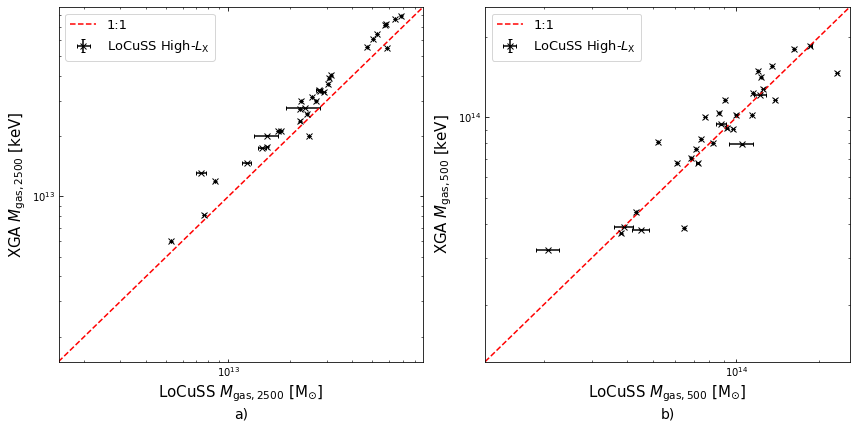

In [19]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_13_gm2500, loc_dblbeta_svikh_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_13r500_gmcomp_dblbeta_svikh.pdf')

In [20]:
loc_dblbeta_svikh_13_gm500.shape

(45, 3)

### Double Beta and Simplified Vikhlinin Profiles - out to 1.1$R_{500}$

In [21]:
loc_dblbeta_11_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.1, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:24<18:17, 24.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 740.09790677 1027.79195877 1047.2841711   775.49846576  793.72661572
  840.3356764 ]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/45 [00:52<19:07, 26.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [467.44500739 303.57937604 452.38218868 435.02903767 424.88675054
 452.34974384]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:17<17:52, 25.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1570.72259575  695.76214995 1717.5317839  1583.77700158 1754.14723135
 1701.30904888]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:39<16:40, 24.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 880.321648   1817.54450548 1861.10864806 1826.33782919 1908.59191924
 2093.05474413]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▍      | 8/45 [03:23<15:54, 25.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 227.48856448  464.94873501 1933.41321693 1878.71630749 1931.27263487
 1844.5543766 ]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 11/45 [04:43<14:48, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [717.17730689 707.38384099 670.05909272 577.49875375 594.59680072
 674.33529779]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:37<14:00, 26.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1294.75137745  285.45251484 1073.93617144 1052.1860192  1149.67482588
 1085.208532  ]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 14/45 [06:02<13:31, 26.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1175.97295495  416.84257712 1021.20243934 1005.30865371 1062.46597374
 1134.1106279 ]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/45 [06:28<13:01, 26.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [848.06308552 848.94867589 793.77312897 836.06592614 858.37644148
 874.97803165]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [06:54<12:29, 25.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [213.05090012 250.34984413 393.90529286 435.79546099 466.34719315
 451.66978459]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 17/45 [07:20<12:05, 25.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 394.45050199  334.73280746 1720.85338843 1273.16431724 1314.01422829
 1410.96321304]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 18/45 [07:43<11:19, 25.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 176.56458704 1161.24814307 2128.70863696 2473.93624098 2450.12441347
 2086.57557718]


Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 21/45 [09:08<10:56, 27.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [517.35696986 524.31618178 465.36171898 456.25577425 466.79088349
 493.4143224 ]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 22/45 [09:37<10:41, 27.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 825.64943737  472.42082247 1901.24830685 1506.94371833 1056.61973079
 1860.83540513]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 24/45 [10:26<09:08, 26.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1045.05923827  981.96064696 2168.6016465  1208.27500449 1381.67977792
 2120.52785716]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 25/45 [10:56<09:02, 27.11s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell1758N's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:19<08:13, 25.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 699.03280015  815.21646322 1289.19850551  780.9190229   671.49206927
 1288.96517225]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 990.6850984  1109.37527123 1320.86198314 1216.72636189 1141.7891173
 1189.26398926]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [14:00<05:42, 26.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 678.11702678  647.10248653 1759.572515   1438.54395435 1809.37560913
 1758.61221697]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 34/45 [14:51<04:45, 25.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1181.16005795  716.09477119 1280.32375294 1325.78684163 1330.36033198
 1330.58800556]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:19<04:28, 26.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [533.77662865 501.28332913 489.22834152 404.81934908 419.77706037
 505.0416352 ]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [18:30<01:19, 26.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1594.18625425  971.9796752  1584.95139447 1246.99356201 1366.96979365
 1431.55055643]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 43/45 [18:57<00:53, 26.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [450.36101464 443.53283627 471.08701199 282.7497555  351.09184904
 516.07762424]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [19:21<00:25, 25.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1100.06008432  928.14923035 1870.20552713 1498.65907992 1346.33976262
 1842.15009749]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [19:45<00:00, 26.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [296.92785331 690.79296739 782.41728488 583.55713564 646.06786509
 776.81049343]


In [22]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   2%|▋                               | 1/45 [00:42<31:29, 42.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 106.98792914  152.72381809 1095.59484503  115.85441989  115.6884329
  453.17972247]


Fitting density model to LoCuSS profiles:   4%|█▍                              | 2/45 [01:29<32:26, 45.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [149.89442201 202.82443168 601.03812739 115.94855437 140.79798384
 250.5214735 ]


Fitting density model to LoCuSS profiles:   7%|██▏                             | 3/45 [02:11<30:30, 43.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [124.97114044 183.4873568  687.06908767 120.70818008 117.29340713
 416.77783517]


Fitting density model to LoCuSS profiles:  11%|███▌                            | 5/45 [03:34<28:09, 42.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [118.91011988 223.84462324 618.78016027 120.19296128 109.71219493
 230.3913382 ]


Fitting density model to LoCuSS profiles:  13%|████▎                           | 6/45 [04:12<26:38, 40.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 99.7265529  100.68310399 983.84883306 119.64016634 133.78503795
  98.66263715]


Fitting density model to LoCuSS profiles:  22%|██████▉                        | 10/45 [07:07<25:06, 43.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 86.55263244  91.32296205 634.46642777  81.13033082  80.62004658
  92.11395231]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [07:49<24:06, 42.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2178.1079367  2353.67983142 1768.24579887 2086.529332   2243.70381573
 1830.99762865]


Fitting density model to LoCuSS profiles:  29%|████████▉                      | 13/45 [09:13<22:34, 42.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [320.14216836 460.57162506 686.98257108 272.09439476 182.7774814
 537.57465288]


Fitting density model to LoCuSS profiles:  33%|██████████▎                    | 15/45 [10:37<20:56, 41.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 99.97521159 111.95581637 941.95427728 114.33382851 121.20820505
 121.30734055]


Fitting density model to LoCuSS profiles:  40%|████████████▍                  | 18/45 [12:47<19:11, 42.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1643.26684498 1655.58777305  423.62975905  785.17809065 1645.50879384
  418.59641105]


Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [13:31<18:40, 43.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 82.59769671  82.08423306 883.3125926   85.29657725  84.92100727
  83.82195736]


Fitting density model to LoCuSS profiles:  60%|██████████████████▌            | 27/45 [18:44<10:21, 34.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  99.22999048  101.60760142 1015.66393049  104.41584276  108.23260739
  104.58149905]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [20:57<09:59, 39.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [101.84145906 101.59318996 746.24676027 110.78946653 123.98145431
  94.55973079]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [22:28<09:08, 42.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1759.70871121 1925.51983939  818.4459757  1985.2384713  1796.18863355
 1315.80129027]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [23:16<08:47, 43.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 73.04381472  74.44683608 686.96918359  86.08325174  86.44272855
  41.56555949]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▍       | 34/45 [24:01<08:06, 44.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [429.66090911 886.98863754 938.72020133 234.21853362 167.5490911
 969.79005877]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [30:14<02:14, 44.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [321.35934842 430.6757199  781.49259321 195.27040693 145.24884793
 493.35033414]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [32:25<00:00, 43.23s/it]


In [23]:
loc_dblbeta_svikh_11_gm500 = []
loc_dblbeta_svikh_11_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_11_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_11_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_11_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_11_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_11_gm500 = Quantity(loc_dblbeta_svikh_11_gm500, 'Msun')
loc_dblbeta_svikh_11_gm2500 = Quantity(loc_dblbeta_svikh_11_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:20<00:00,  9.79s/it]


In [24]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_11_gm2500[:, 0]).sum(), t=len(loc_dblbeta_svikh_11_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_11_gm500[:, 0]).sum(), t=len(loc_dblbeta_svikh_11_gm500)))

44 out of 45 R2500 gas mass measurements produced a result
44 out of 45 R500 gas mass measurements produced a result


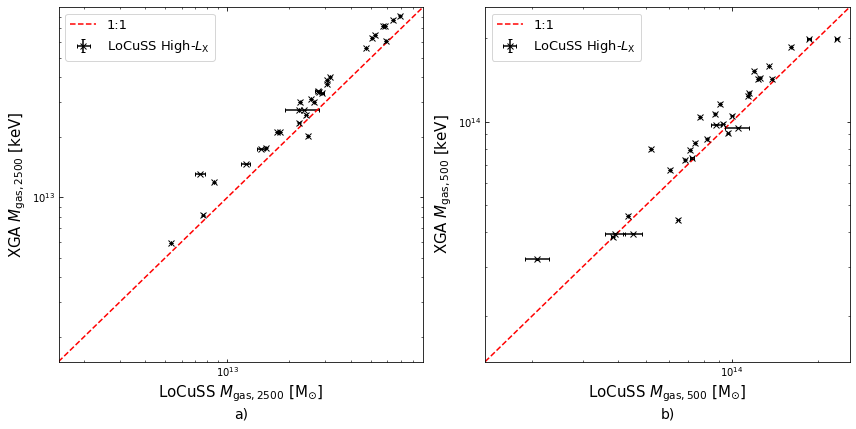

In [25]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_11_gm2500, loc_dblbeta_svikh_11_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'